# **CIFAR-10 CNN and ResNet Transfer Learning**
This notebook demonstrates the performance differences of using a Convolutional Neural Network (CNN) to classify CIFAR-10 images vs ResNet Transfer Learning.

# **1. Import Packages**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16,ResNet50
from sklearn.metrics import classification_report
from tensorflow.keras import datasets, layers, models, metrics
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

# Check TensorFlow version
print(tf.config.list_physical_devices('GPU'))
print('TensorFlow version: {}'.format(tf.__version__))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.15.0


# **2. Data Preprocessing**
Before building any ML model, it is important to preprocess the data. In fact, data preprocessing will generally take up the most time in any ML pipeline. The following module goes over the steps to preprocess the CIFAR10 dataset for our purposes.

## Download and prepare the CIFAR10 dataset
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

One thing to keep in mind is that One-hot encoding doesn't perform well if the categorical variable is taking up a large number of values, say such as 15 different values.

In [2]:
(train_images, train_labels), (test_images, test_labels), = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [3]:
# Visualize dataset shapes
print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"test_images shape: {test_images.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


## Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

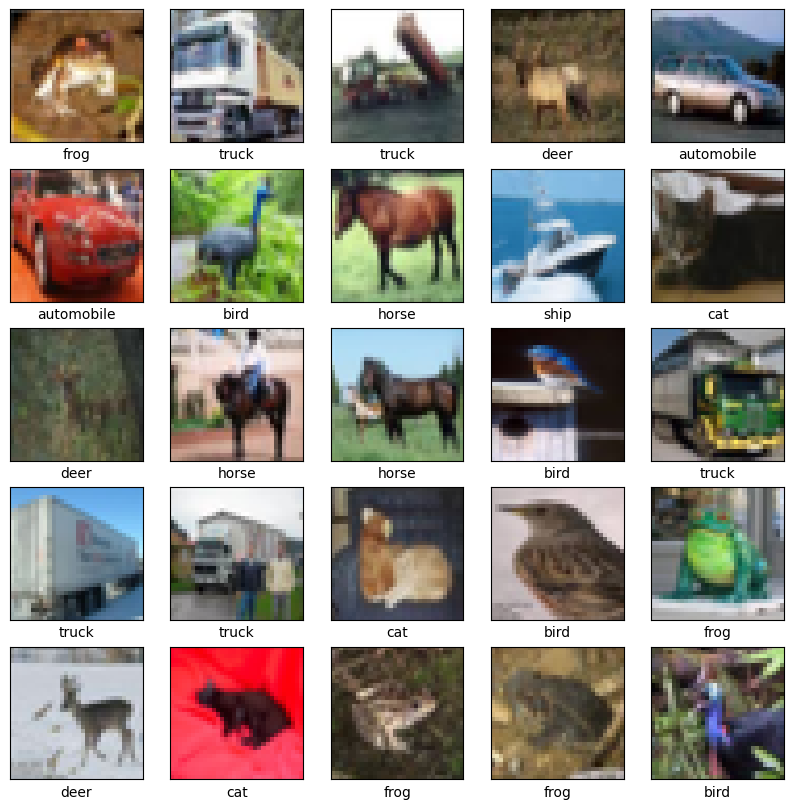

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Configure the dataset for performance
We'll use buffered prefetching to yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [5]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_images = train_images.cache().prefetch(buffer_size=AUTOTUNE)
#train_labels = train_labels.cache().prefetch(buffer_size=AUTOTUNE)
#test_images = test_images.cache().prefetch(buffer_size=AUTOTUNE)
#test_labels = test_labels.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range

In [6]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [7]:
# One hot encoding the labels
cat_train_labels =  to_categorical(train_labels, 10)
cat_test_labels = to_categorical(test_labels, 10)

In [8]:
cat_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# **3. CNN Model Training**

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [9]:
# Build model with Keras Sequential API
# Initialize the Sequential API and start stacking the layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
    
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
    

# Add Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10))

# Summarize the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

The network summary shows that (4, 4, 128) outputs were flattened into vectors of shape (2048) before going through two Dense layers.

In [63]:
len(model.trainable_variables)

28

## Set Evaluation Metric
Here we include the following 4 metrics:
* Classification accuracy
* Precision
* Recall
* F1-score

In [127]:
METRICS = [
    metrics.CategoricalAccuracy(name="accuracy"),
    metrics.Precision(name='precision'),
    metrics.Recall(thresholds=0,name='recall'), 
    metrics.F1Score(average='macro',name='f1_score')
]

## Compile the model
For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`.

In [11]:
# Compile and train the model
#base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)
history = model.fit(train_images, cat_train_labels, epochs=50, 
                    validation_data=(test_images, cat_test_labels))

Epoch 1/50


2024-02-24 20:11:38.239733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708805501.202255      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 22s 9ms/step - loss: 1.5611 - accuracy: 0.4408 - precision: 0.2140 - recall: 0.8923 - f1_score: 0.4365 - val_loss: 1.1870 - val_accuracy: 0.5708 - val_precision: 0.2080 - val_recall: 0.9676 - val_f1_score: 0.5627
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1747 - accuracy: 0.5849 - precision: 0.2099 - recall: 0.9537 - f1_score: 0.5818 - val_loss: 1.0478 - val_accuracy: 0.6231 - val_precision: 0.2136 - val_recall: 0.9708 - val_f1_score: 0.6244
Epoch 3/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0016 - accuracy: 0.6513 - precision: 0.1970 - recall: 0.9720 - f1_score: 0.6497 - val_loss: 0.9586 - val_accuracy: 0.6725 - val_precision: 0.1988 - val_recall: 0.9755 - val_f1_score: 0.6632
Epoch 4/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8852 - accuracy: 0.6950 - precision: 0.1977 - recall: 0.9776 - f1_score: 0.6942 - val_loss: 0.7972 - val_accuracy: 0.7275 - v

# **4. Model Evaluation**

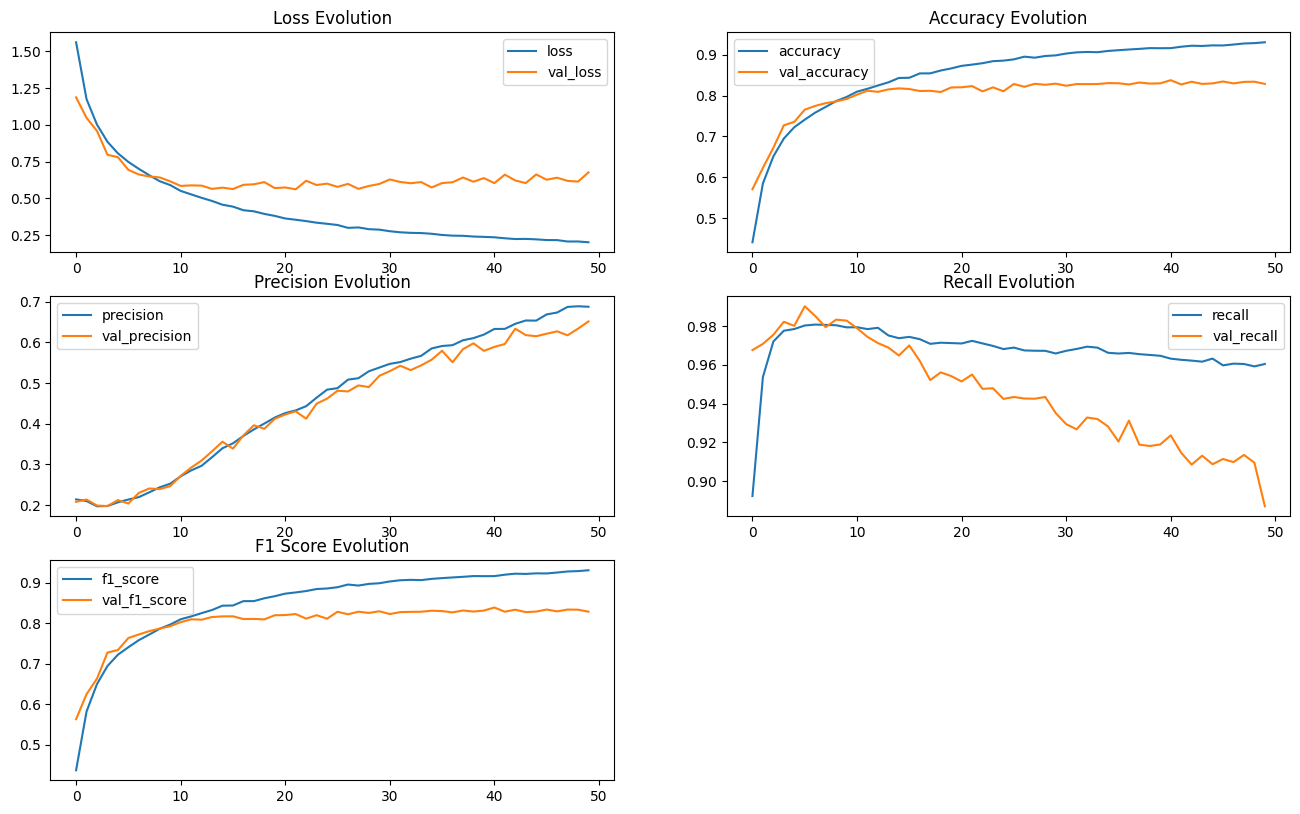

In [12]:
# Plot the model performance
plt.figure(figsize=(16,20))

plt.subplot(6,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(6,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Evolution')
plt.legend()
         
plt.subplot(6,2,3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Evolution')
plt.legend()
         
plt.subplot(6,2,4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Evolution')
plt.legend()
         
plt.subplot(6,2,5)
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.title('F1 Score Evolution')
plt.legend()

As we can see we achieve high precision but low recall

In [13]:
from sklearn.metrics import classification_report

evaluation = model.evaluate(test_images, cat_test_labels)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

labels_pred = model.predict(test_images)
labels_pred = np.argmax(labels_pred, axis=1)

print(classification_report(test_labels, labels_pred))

313/313 [==============================] - 1s 4ms/step - loss: 0.6775 - accuracy: 0.8289 - precision: 0.6512 - recall: 0.8870 - f1_score: 0.8286
Test Accuracy : 82.89%
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.92      0.90      0.91      1000
           2       0.81      0.74      0.77      1000
           3       0.69      0.69      0.69      1000
           4       0.82      0.81      0.81      1000
           5       0.74      0.76      0.75      1000
           6       0.88      0.85      0.87      1000
           7       0.91      0.83      0.87      1000
           8       0.86      0.93      0.90      1000
           9       0.84      0.91      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



# **4. ResNet50 Transfer Learning and Fine-tuning**
In this part, we will finetune the ResNet50 model:

* **Fine-Tuning:** Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

We will follow the general machine learning workflow.

* Compose the model
* Load in the pretrained base model (and pretrained weights)
* Stack the classification layers on top
* Train the model
* Evaluate model

## Create the base model from the pre-trained model

First, instantiate a ResNet50 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction and fine tuning.

We need to pick which layer of ResNet we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.


In [14]:
# Create the base model
IMG_SHAPE = (32, 32, 3)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

94765736/94765736 [==============================] - 4s 0us/step


In [15]:
feature_batch = base_model(train_images)
print(feature_batch.shape)

(50000, 1, 1, 2048)


In [92]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Finetuning

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.



## Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.
**Note:** Be careful of [BatchNormalization](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers) layer

In [312]:
base_model.trainable = True

In [156]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [313]:
# Fine-tune from this layer onwards
fine_tune_at = 158

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Add a classification head
To generate predictions from the block of features, average over spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 2048-element vector per image.

In [314]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(50000, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into 10 classes per image. You don't need an activation function here because this prediction will be treated as a **logit**, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional_api). As previously mentioned, use `training=False` as our model contains a BatchNormalization `layer.tf.keras.callbacks.ReduceLROnPlateau` to reduce learning rate when a metric has stopped improving.



In [315]:
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

In [316]:
resnet_model = models.Sequential()
resnet_model.add(layers.Input(shape=IMG_SHAPE))
resnet_model.add(base_model)
resnet_model.add(global_average_layer)
#resnet_model.add(layers.Flatten())
#resnet_model.add(layers.Dropout(0.2))
#resnet_model.add(layers.Dense(1020, activation='relu'))
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(10))

We can also check how many `tf.Variable` objects are used for training after freezing layers

In [317]:
len(resnet_model.trainable_variables)

26

In [318]:
resnet_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_123 (Dense)           (None, 512)               1049088   
                                                                 
 dense_124 (Dense)           (None, 256)               131328    
                                                                 
 dropout_51 (Dropout)        (None, 256)               0         
                                                                 
 dense_125 (Dense)           (None, 10)                2570      
                                                     

The 23+ million parameters in ResNet are frozen, but there are 20 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

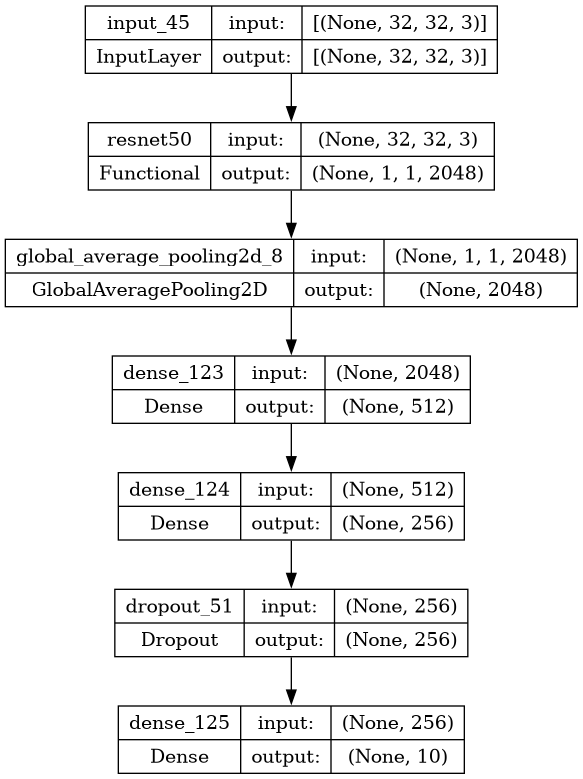

In [319]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

## Compile the model
As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [320]:
#base_learning_rate = 1e-6
resnet_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = 'sgd',
              metrics=METRICS)

# **Train the model**

In [321]:
initial_epochs = 10

resnet_h = resnet_model.fit(train_images, cat_train_labels,
                            epochs=initial_epochs,
                            batch_size=64,
                            validation_data=(test_images, cat_test_labels),
                            callbacks=[lrr])

Epoch 1/10
782/782 [==============================] - 24s 24ms/step - loss: 0.5132 - accuracy: 0.8518 - precision: 0.3510 - recall: 0.9855 - f1_score: 0.8516 - val_loss: 0.6162 - val_accuracy: 0.8077 - val_precision: 0.3480 - val_recall: 0.9800 - val_f1_score: 0.8072 - lr: 0.0100
Epoch 2/10
782/782 [==============================] - 15s 20ms/step - loss: 0.3722 - accuracy: 0.8769 - precision: 0.3346 - recall: 0.9923 - f1_score: 0.8768 - val_loss: 0.6176 - val_accuracy: 0.8075 - val_precision: 0.3286 - val_recall: 0.9820 - val_f1_score: 0.8068 - lr: 0.0100
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.3672 - accuracy: 0.8780 - precision: 0.3236 - recall: 0.9927 - f1_score: 0.8779 - val_loss: 0.6176 - val_accuracy: 0.8058 - val_precision: 0.3236 - val_recall: 0.9825 - val_f1_score: 0.8051 - lr: 0.0100
Epoch 4/10
782/782 [==============================] - 15s 20ms/step - loss: 0.3623 - accuracy: 0.8803 - precision: 0.3200 - recall: 0.9932 - f1_score: 0.8803

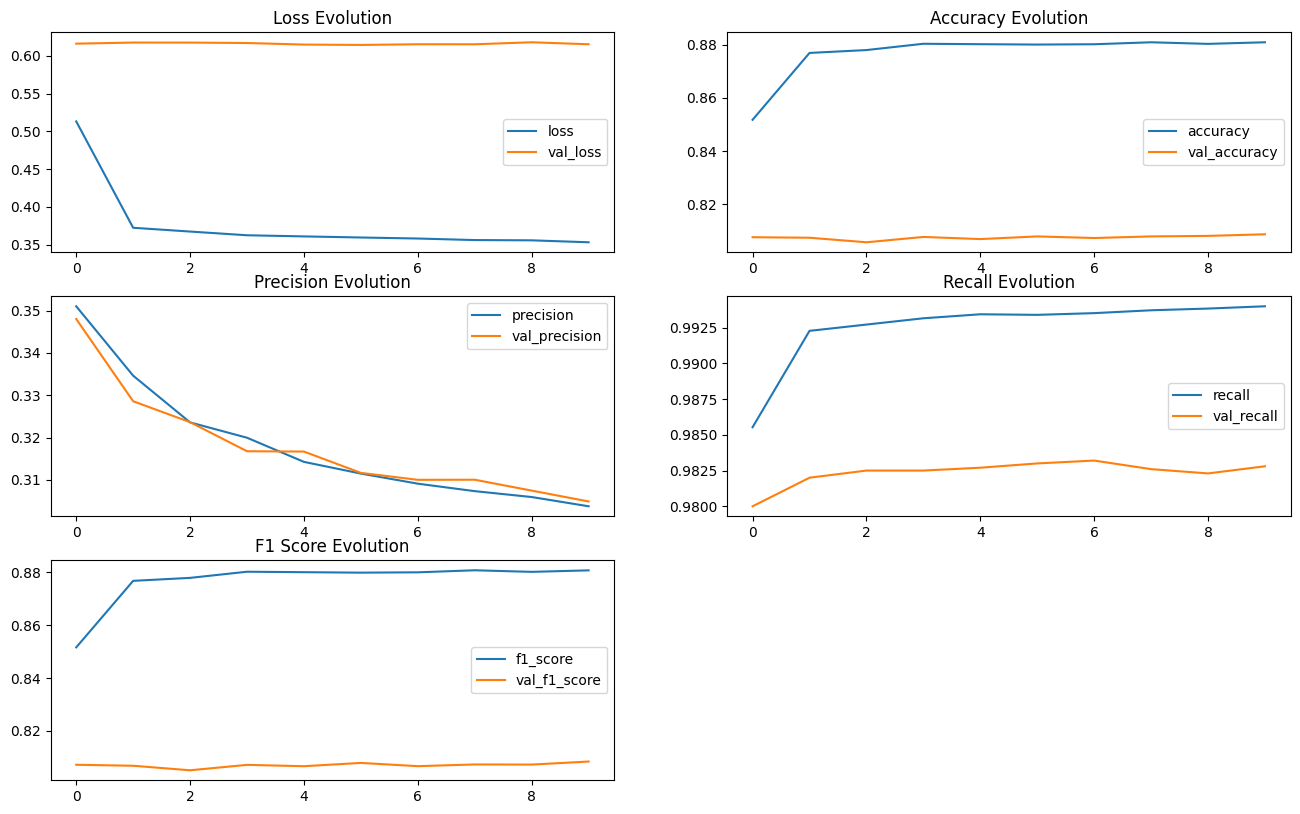

In [322]:
# Plot the model performance
plt.figure(figsize=(16,20))

plt.subplot(6,2,1)
plt.plot(resnet_h.history['loss'], label='loss')
plt.plot(resnet_h.history['val_loss'], label='val_loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(6,2,2)
plt.plot(resnet_h.history['accuracy'], label='accuracy')
plt.plot(resnet_h.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Evolution')
plt.legend()
         
plt.subplot(6,2,3)
plt.plot(resnet_h.history['precision'], label='precision')
plt.plot(resnet_h.history['val_precision'], label='val_precision')
plt.title('Precision Evolution')
plt.legend()
         
plt.subplot(6,2,4)
plt.plot(resnet_h.history['recall'], label='recall')
plt.plot(resnet_h.history['val_recall'], label='val_recall')
plt.title('Recall Evolution')
plt.legend()
         
plt.subplot(6,2,5)
plt.plot(resnet_h.history['f1_score'], label='f1_score')
plt.plot(resnet_h.history['val_f1_score'], label='val_f1_score')
plt.title('F1 Score Evolution')
plt.legend()

In [323]:
from sklearn.metrics import classification_report

evaluation = resnet_model.evaluate(test_images, cat_test_labels)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

fine_labels_pred = resnet_model.predict(test_images)
fine_labels_pred = np.argmax(fine_labels_pred, axis=1)

print(classification_report(test_labels, labels_pred))

313/313 [==============================] - 4s 12ms/step - loss: 0.6154 - accuracy: 0.8088 - precision: 0.3049 - recall: 0.9828 - f1_score: 0.8084
Test Accuracy : 80.88%
313/313 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.92      0.90      0.91      1000
           2       0.81      0.74      0.77      1000
           3       0.69      0.69      0.69      1000
           4       0.82      0.81      0.81      1000
           5       0.74      0.76      0.75      1000
           6       0.88      0.85      0.87      1000
           7       0.91      0.83      0.87      1000
           8       0.86      0.93      0.90      1000
           9       0.84      0.91      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

